# Machine Learning Final Project

### Installing ncessary libraries

In [1]:
!pip install jovian --upgrade --quiet
!pip install opendatasets --quiet
!pip install xgboost --quiet
!pip install mlxtend --quiet

### Importing Necessary modules and libraries

In [2]:
import jovian
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

import warnings
warnings.filterwarnings("ignore")

### Commiting the file to Jovian

In [3]:
# Execute this to save new versions of the notebook
jovian.commit(project="project101")

<IPython.core.display.Javascript object>

[jovian] Updating notebook "geo4367/machine-learning-final-project" on https://jovian.ai
[jovian] Committed successfully! https://jovian.ai/geo4367/machine-learning-final-project


'https://jovian.ai/geo4367/machine-learning-final-project'

### Downloading the Insurance File

In [4]:
import opendatasets as od
od.download('https://www.kaggle.com/competitions/prudential-life-insurance-assessment')

# username	"georgekuttyantony"
# key	"33f55414eeb72f18e1ec7b60a796eccf"

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: georgekuttyantony
Your Kaggle Key: ········


100%|██████████| 3.24M/3.24M [00:00<00:00, 64.5MB/s]


Extracting archive ./prudential-life-insurance-assessment/prudential-life-insurance-assessment.zip to ./prudential-life-insurance-assessment


### Unziping the files

In [5]:
import zipfile, os
working_directory = 'prudential-life-insurance-assessment/'
for file in os.listdir(working_directory): 
    if zipfile.is_zipfile(working_directory+file):
        with zipfile.ZipFile(working_directory+file, 'r') as item: 
            item.extractall()

### Loading the files

In [6]:
pd.set_option('display.max_columns', None)
df = train_df  =pd.read_csv('train.csv', index_col='Id')
test_df = pd.read_csv('test.csv')
submit = pd.read_csv('sample_submission.csv')

### Feature Engineering

In [7]:
df['Modified_Response']  = df['Response'].map(lambda x : 0 if x<=7 and x>=0 else 1)
cat  = 'Product_Info_1, Product_Info_2, Product_Info_3, Product_Info_5, Product_Info_6, Product_Info_7, Employment_Info_2, Employment_Info_3, Employment_Info_5, InsuredInfo_1, InsuredInfo_2, InsuredInfo_3, InsuredInfo_4, InsuredInfo_5, InsuredInfo_6, InsuredInfo_7, Insurance_History_1, Insurance_History_2, Insurance_History_3, Insurance_History_4, Insurance_History_7, Insurance_History_8, Insurance_History_9, Family_Hist_1, Medical_History_2, Medical_History_3, Medical_History_4, Medical_History_5, Medical_History_6, Medical_History_7, Medical_History_8, Medical_History_9, Medical_History_11, Medical_History_12, Medical_History_13, Medical_History_14, Medical_History_16, Medical_History_17, Medical_History_18, Medical_History_19, Medical_History_20, Medical_History_21, Medical_History_22, Medical_History_23, Medical_History_25, Medical_History_26, Medical_History_27, Medical_History_28, Medical_History_29, Medical_History_30, Medical_History_31, Medical_History_33, Medical_History_34, Medical_History_35, Medical_History_36, Medical_History_37, Medical_History_38, Medical_History_39, Medical_History_40, Medical_History_41'
categorical = cat.split(', ')
cont = 'Product_Info_4, Ins_Age, Ht, Wt, BMI, Employment_Info_1, Employment_Info_4, Employment_Info_6, Insurance_History_5, Family_Hist_2, Family_Hist_3, Family_Hist_4, Family_Hist_5'
continuous = cont.split(', ')
disc = 'Medical_History_1, Medical_History_10, Medical_History_15, Medical_History_24, Medical_History_32'
discrete = disc.split(', ')
dummy = []
for i in range(1, 49):
    dummy.append('Medical_Keyword_'+str(i))

df_new = df[categorical+ discrete+ continuous+ dummy + ['Modified_Response']]
corr = df_new.corr()
corr_greater_than_80 = corr[corr>=.8]
is_null_count = df_new.isnull().sum()/len(df_new)

null_col = is_null_count[is_null_count>.4].sort_values(ascending = False).index.tolist()
df_new = df_new.drop(null_col, axis = 1)
test_cols = list(df_new.columns)

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(df_new[['Product_Info_2']])
encoded_cols = list(encoder.get_feature_names_out(['Product_Info_2']))
df_new[encoded_cols] = encoder.transform(df_new[['Product_Info_2']])
df_new.drop('Product_Info_2', axis = 1, inplace = True)
numeric_cols = df_new.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df_new.select_dtypes(include='object').columns.tolist()
imputer = SimpleImputer().fit(df_new[numeric_cols])
df_new[numeric_cols] = imputer.transform(df_new[numeric_cols])

Since many of the continuous variable columns are removed, we need to make sure that those are removed from the continuous
list 

In [8]:
new_cond = ['Product_Info_4',
 'Ins_Age',
 'Ht',
 'Wt',
 'BMI',
 'Employment_Info_1',
 'Employment_Info_4',
 'Employment_Info_6',
 'Family_Hist_4']

scaler = MinMaxScaler().fit(df_new[new_cond])
df_new[new_cond] = scaler.transform(df_new[new_cond])

df_new[new_cond].describe()

inputs_df= df_new.drop('Modified_Response',axis=1).copy()
targets = df_new['Modified_Response'].copy()

# Create training and validation sets
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df, targets, test_size=0.25, random_state=42)

train_inputs.shape, val_inputs.shape
len(train_targets), len(val_targets)

(44535, 14846)

### Test DataFrame 

#### Manipulating the test data

In [9]:
test_cols.remove('Modified_Response')
test = test_df[test_cols]

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(test[['Product_Info_2']])
encoded_cols = list(encoder.get_feature_names_out(['Product_Info_2']))

encoder.transform(test[['Product_Info_2']]).copy()
test[encoded_cols] = encoder.transform(test[['Product_Info_2']])
test.drop('Product_Info_2', axis = 1, inplace = True)
numeric_cols.remove('Modified_Response')

imputer = SimpleImputer().fit(test[numeric_cols])
test[numeric_cols] = imputer.transform(test[numeric_cols])

scaler = MinMaxScaler().fit(test[new_cond])
test[new_cond] = scaler.transform(test[new_cond])

# Decision Tree implementation

### Hyperparameter tuning

In [35]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(train_inputs, train_targets)
    train_err = 1 - model.score(train_inputs, train_targets)
    val_err = 1 - model.score(val_inputs, val_targets)
    return {'Max Depth': md, 'Training Error': train_err, 'Validation Error': val_err}

errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

The above code will help us to visualize the optimal max_depth, where both training and validation error are the lowest possible

In [36]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.329381,0.324667
1,2,0.274279,0.270039
2,3,0.206557,0.201064
3,4,0.197934,0.192375
4,5,0.191827,0.186043
5,6,0.191310,0.186178
6,7,0.185023,0.184561
7,8,0.179769,0.186919
8,9,0.174020,0.184157
9,10,0.166296,0.183484


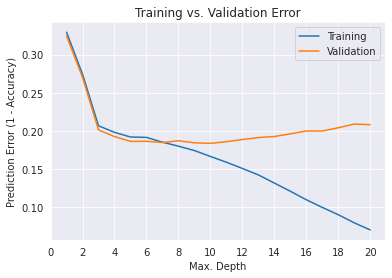

In [37]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation']);

This shows that a max_depth of 7 gives the lowest validation and training errors. They lie closer to each other as well.

### Grid-Search 

Grid search will try every possible combinations of hyperparameters and comes out with that optimal combination where training score is the highest

In [25]:
clf = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid={'min_samples_split' : [2, 3, 5, 7], 'min_samples_leaf' : [2, 3, 5, 7], 'max_depth' : [5, 6, 7, 8]}, return_train_score = False, n_jobs = -1)
clf.fit(train_inputs, train_targets)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8],
                         'min_samples_leaf': [2, 3, 5, 7],
                         'min_samples_split': [2, 3, 5, 7]})

### Best Tree
is the best tree that came out from gridsearch

In [26]:
best_tree = clf.best_estimator_

In [27]:
clf.best_score_

0.8098349612664197

In [28]:
clf.best_params_

{'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 2}

In [29]:
df = pd.DataFrame(clf.cv_results_)
df[['param_min_samples_leaf', 'param_min_samples_split', 'param_max_depth', 'mean_test_score']].sort_values('mean_test_score', ascending= False).head(5)

,param_min_samples_leaf,param_min_samples_split,param_max_depth,mean_test_score
63,7,7,8,0.809835
60,7,2,8,0.809835
62,7,5,8,0.809835
61,7,3,8,0.809835
51,2,7,8,0.809655


In [30]:
best_tree.fit(train_inputs, train_targets)
best_tree.score(train_inputs, train_targets), best_tree.score(val_inputs, val_targets)

(0.8191759290445717, 0.813889263101172)

In [31]:
tree_importances = best_tree.feature_importances_

tree_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_importances
}).sort_values('importance', ascending=False)

tree_importance_df.head(10)

,feature,importance
64,BMI,0.436558
42,Medical_History_23,0.191587
25,Medical_History_4,0.172192
60,Product_Info_4,0.053386
71,Medical_Keyword_3,0.029622
63,Wt,0.028254
61,Ins_Age,0.017781
48,Medical_History_30,0.016318
83,Medical_Keyword_15,0.013910
13,InsuredInfo_6,0.008559


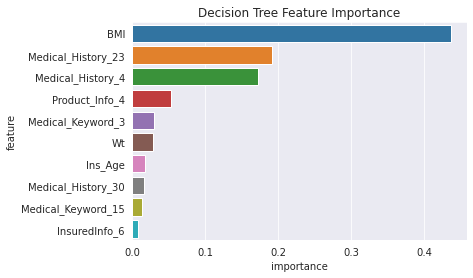

In [32]:
plt.title('Decision Tree Feature Importance')
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature');

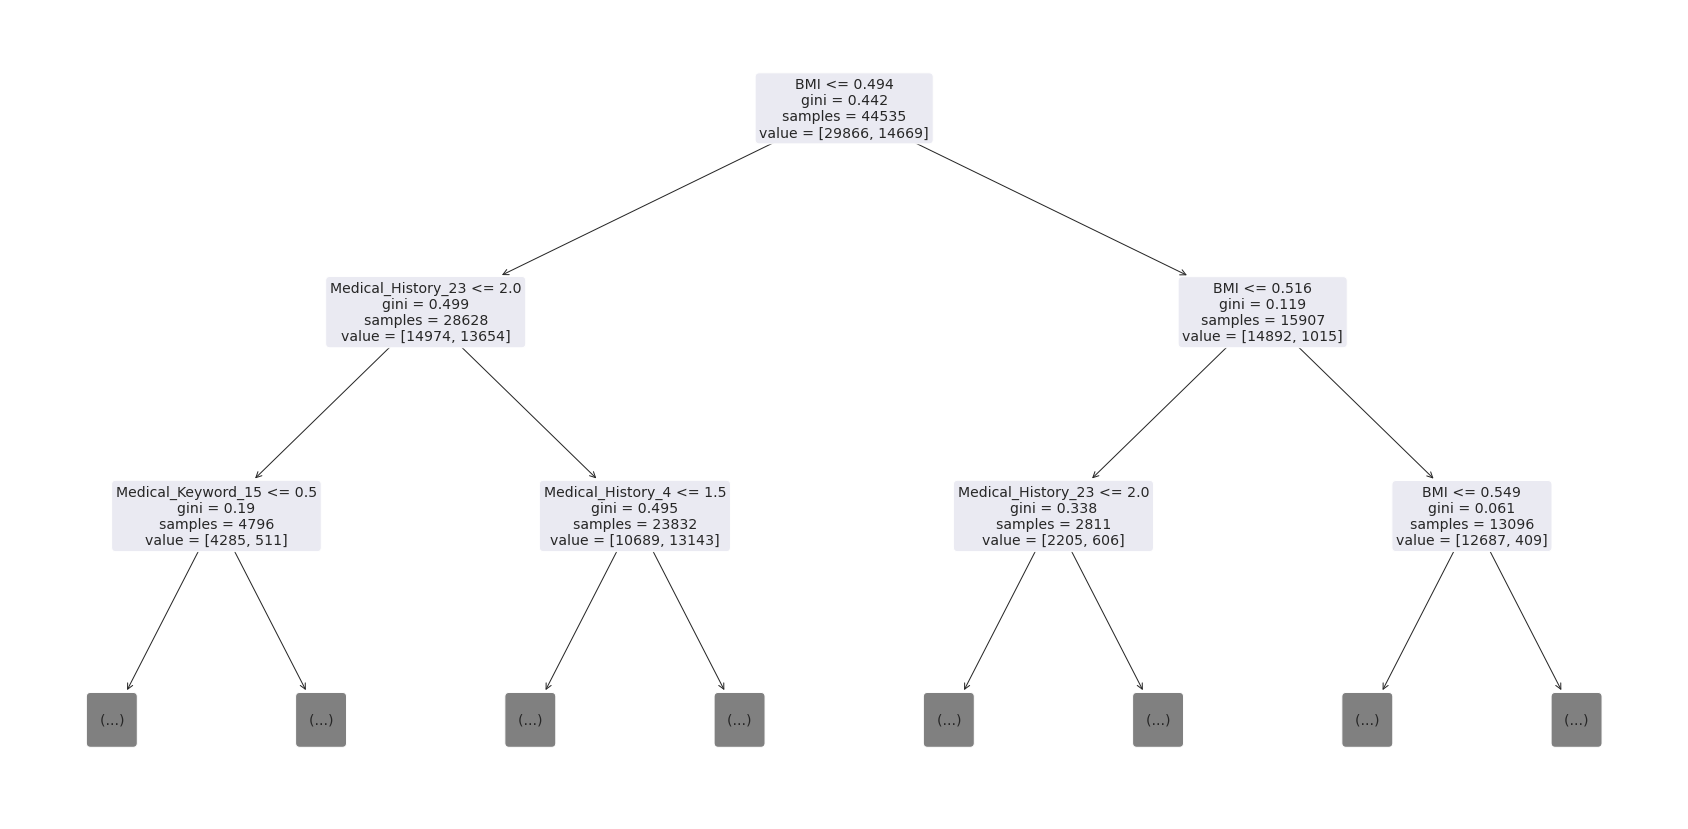

In [33]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
plt.figure(figsize=(30,15))

# Visualize the tree graphically using plot_tree
plot_tree(best_tree, max_depth = 2, feature_names = train_inputs.columns, rounded = True);

In [34]:
tree_text = export_text(best_tree, feature_names = list(train_inputs.columns), max_depth = 6)
print(tree_text[:2000])

|--- BMI <= 0.49
|   |--- Medical_History_23 <= 2.00
|   |   |--- Medical_Keyword_15 <= 0.50
|   |   |   |--- Medical_Keyword_35 <= 0.50
|   |   |   |   |--- Medical_History_4 <= 1.50
|   |   |   |   |   |--- Medical_History_39 <= 2.00
|   |   |   |   |   |   |--- Medical_Keyword_33 <= 0.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- Medical_Keyword_33 >  0.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- Medical_History_39 >  2.00
|   |   |   |   |   |   |--- Product_Info_2_D4 <= 0.50
|   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |--- Product_Info_2_D4 >  0.50
|   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |--- Medical_History_4 >  1.50
|   |   |   |   |   |--- Ins_Age <= 0.47
|   |   |   |   |   |   |--- Wt <= 0.25
|   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |--- Wt >  0.25
|   |   |   |   |   |   |   |--- truncated branch o

# Random Forest Implementation

### Initializing a Grid Search : Producing a optimized model  running all  combinations of parameters specified

In [39]:
n_estimators = [50,80,100]
max_depth = [4,6,8]
min_samples_split = [50,100,150]
min_samples_leaf = [40,50]

rf_parameters = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
                       param_grid = rf_parameters,
                       cv = 2, scoring='roc_auc')

grid.fit(train_inputs,train_targets)

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [4, 6, 8], 'min_samples_leaf': [40, 50],
                         'min_samples_split': [50, 100, 150],
                         'n_estimators': [50, 80, 100]},
             scoring='roc_auc')

### Best random Forest

In [40]:
best_rf = grid.best_estimator_

In [41]:
grid.best_params_

{'max_depth': 8,
 'min_samples_leaf': 40,
 'min_samples_split': 150,
 'n_estimators': 100}

In [42]:
best_rf.fit(train_inputs, train_targets)
best_rf.score(train_inputs, train_targets), best_rf.score(val_inputs, val_targets)

(0.8098798697653531, 0.8089721137006601)

In [43]:
tree_importances = best_rf.feature_importances_

tree_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_importances
}).sort_values('importance', ascending=False)

tree_importance_df.head(10)

,feature,importance
64,BMI,0.247382
63,Wt,0.185423
42,Medical_History_23,0.113254
25,Medical_History_4,0.095488
83,Medical_Keyword_15,0.086082
60,Product_Info_4,0.036178
13,InsuredInfo_6,0.033401
68,Family_Hist_4,0.025360
61,Ins_Age,0.024931
71,Medical_Keyword_3,0.018681


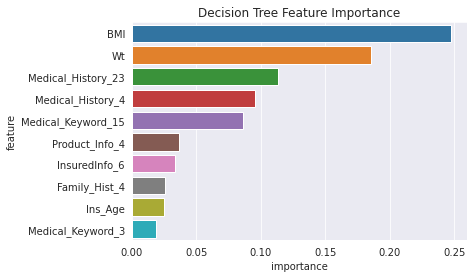

In [44]:
plt.title('Decision Tree Feature Importance')
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature');

# Gradient Boosting Machines (GBMs) with XGBoost

### Grid_Search

In [55]:
gb_parameters ={
    "n_estimators":[5,50,250],
    "max_depth":[1,3,5,7],
    "learning_rate":[0.01,0.1,1]
}
clf = GridSearchCV(GradientBoostingClassifier(), param_grid = gb_parameters, return_train_score = False)
clf.fit(train_inputs, train_targets)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [1, 3, 5, 7],
                         'n_estimators': [5, 50, 250]})

### Best Gradient Descent

In [56]:
best_gd = clf.best_estimator_

In [57]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}

In [58]:
clf.best_score_

0.8293926125519254

In [59]:
clf.cv_results_

{'mean_fit_time': array([ 0.21491847,  1.90104208,  9.50637231,  0.5898489 ,  5.85492749,
        29.28050365,  1.04773622, 10.22195153, 52.89058948,  1.52175674,
        18.41845312, 75.46308827,  0.22819371,  1.89952354,  9.45016913,
         0.61289802,  5.77543359, 27.61365733,  1.05720816, 10.45120401,
        47.34110551,  1.55489798, 14.68483434, 68.12238159,  0.23639197,
         1.91000395,  9.44901385,  0.58432508,  5.50114508, 27.74856062,
         1.03752642,  9.56140156, 47.89878216,  1.45156317, 13.74810476,
        69.22017245]),
 'std_fit_time': array([0.00282111, 0.02690815, 0.25579155, 0.00427186, 0.0710179 ,
        0.50134903, 0.02043415, 0.07691417, 1.26411823, 0.02039325,
        1.966802  , 0.55341628, 0.00651303, 0.02651926, 0.08614144,
        0.00911623, 0.08256527, 0.18072485, 0.03464279, 0.26459057,
        0.37111085, 0.03940823, 0.15522181, 0.40794933, 0.01654057,
        0.00850378, 0.10037427, 0.01206938, 0.07401088, 0.35527961,
        0.02077787, 0.099

In [60]:
best_gd.score(train_inputs, train_targets), best_gd.score(val_inputs, val_targets)

(0.8619512742786573, 0.8345008756567426)

In [61]:
# Execute this to save new versions of the notebook
jovian.commit(project="project101")

<IPython.core.display.Javascript object>

[jovian] Updating notebook "geo4367/machine-learning-final-project" on https://jovian.ai
[jovian] Committed successfully! https://jovian.ai/geo4367/machine-learning-final-project


'https://jovian.ai/geo4367/machine-learning-final-project'

In [95]:
tree_importances = best_gd.feature_importances_

tree_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_importances
}).sort_values('importance', ascending=False)

tree_importance_df.head(10)

,feature,importance
64,BMI,0.391214
25,Medical_History_4,0.132272
42,Medical_History_23,0.128868
60,Product_Info_4,0.050923
61,Ins_Age,0.032940
63,Wt,0.032573
83,Medical_Keyword_15,0.032421
71,Medical_Keyword_3,0.022549
13,InsuredInfo_6,0.016588
68,Family_Hist_4,0.012263


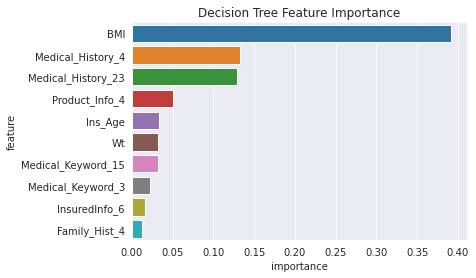

In [96]:
plt.title('Decision Tree Feature Importance')
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature');

# XGBoost

### Initializing a Grid search

In [67]:
# Parameter grid for xgboost
xgb_parameters = {'max_depth': [1,3,5], 'n_estimators': [2,5,10], 'learning_rate': [.01 , .1, .5]}

In [68]:
clf = GridSearchCV(XGBClassifier(), param_grid = xgb_parameters, return_train_score = False)
clf.fit(train_inputs, train_targets)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [1, 3, 5], 'n_estimators': [2, 5, 10]})

### Best XGBoost

In [69]:
best_xgb = clf.best_estimator_

In [70]:
clf.best_score_

0.8215336252385764

In [71]:
clf.best_params_

{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 10}

In [72]:
best_xgb.fit(train_inputs, train_targets)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [73]:
best_xgb.score(train_inputs, train_targets), best_xgb.score(val_inputs, val_targets)

(0.8270573706073875, 0.824464502222821)

In [74]:
train_preds_prob = best_xgb.predict_proba(train_inputs)[:,1]
val_preds_prob = best_xgb.predict_proba(val_inputs)[:,1]
# Get the roc_auc score for train and test dataset
train_roc = roc_auc_score(train_targets,train_preds_prob)
val_roc = roc_auc_score(val_targets,val_preds_prob)

train_roc, val_roc

(0.9048886192991362, 0.8998767623266644)

In [75]:
tree_importances = best_xgb.feature_importances_

tree_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_importances
}).sort_values('importance', ascending=False)

tree_importance_df.head(10)

,feature,importance
42,Medical_History_23,0.194126
64,BMI,0.131602
25,Medical_History_4,0.108218
83,Medical_Keyword_15,0.060940
14,InsuredInfo_7,0.052034
71,Medical_Keyword_3,0.048733
13,InsuredInfo_6,0.032331
109,Medical_Keyword_41,0.026657
26,Medical_History_5,0.025853
60,Product_Info_4,0.025080


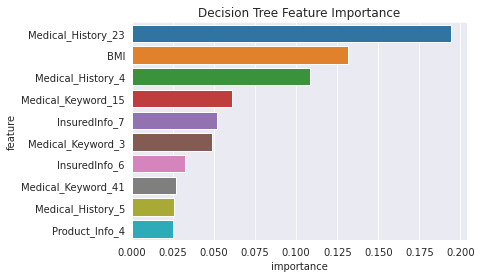

In [76]:
plt.title('Decision Tree Feature Importance')
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature');

# Logistic Regression

### Grid_Search

In [77]:
# parameter grid

parameters = {
    'penalty' : ['l1'], 
    'C'       : np.logspace(-3,3,3),
    'solver'  : ['liblinear'],
}


# parameters = {
#     'penalty' : ['l1','l2'], 
#     'C'       : np.logspace(-3,3,3),
#     'solver'  : ['liblinear'],
# }


# parameters = {
#     'penalty' : ['l1','l2'], 
#     'C'       : np.logspace(-3,3,3),
#     'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
# }

In [78]:
logreg = LogisticRegression(max_iter=5000)
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

In [79]:
clf.fit(train_inputs, train_targets)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=5000),
             param_grid={'C': array([1.e-03, 1.e+00, 1.e+03]),
                         'penalty': ['l1'], 'solver': ['liblinear']},
             scoring='accuracy')

### Best LogReg

In [80]:
best_logreg= clf.best_estimator_

In [81]:
clf.best_score_

0.8149995900908265

In [82]:
clf.best_params_

{'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}

In [83]:
best_logreg.score(train_inputs, train_targets), best_logreg.score(val_inputs, val_targets)

(0.8169754125968339, 0.8129462481476492)

In [84]:
tree_importances = best_logreg.coef_[0]
tree_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_importances
}).sort_values('importance', ascending=False)

tree_importance_df.head(10)

,feature,importance
62,Ht,3.831540
109,Medical_Keyword_41,1.824301
25,Medical_History_4,1.249048
39,Medical_History_20,1.223509
57,Medical_History_40,0.894626
36,Medical_History_17,0.739284
60,Product_Info_4,0.703839
68,Family_Hist_4,0.640559
111,Medical_Keyword_43,0.633416
80,Medical_Keyword_12,0.600949


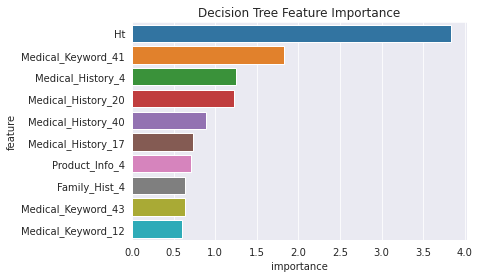

In [85]:
plt.title('Decision Tree Feature Importance')
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature');

# Max Voting Model

In [86]:
voting_model = VotingClassifier([('tr', best_tree), ('rf', best_rf), ('gd', best_gd), ('xgb', best_xgb), ('lr', best_logreg)], voting='soft')
voting_model.fit(train_inputs, train_targets)
voting_model.score(train_inputs, train_targets), voting_model.score(val_inputs, val_targets)

(0.8354103514090041, 0.8302573083658898)

### JobLib

In [87]:
best_est = {'tr': best_tree, 
            'rf': best_rf, 
            'gd': best_gd, 
            'xgb': best_xgb, 
            'lr': best_logreg, 
            'vm': voting_model
}

In [88]:
joblib.dump(best_est, 'best_est.joblib')

['best_est.joblib']

In [89]:
jovian.commit(outputs=['best_est.joblib'])

<IPython.core.display.Javascript object>

[jovian] Updating notebook "geo4367/machine-learning-final-project" on https://jovian.ai
[jovian] Uploading additional outputs...
[jovian] Committed successfully! https://jovian.ai/geo4367/machine-learning-final-project


'https://jovian.ai/geo4367/machine-learning-final-project'

### Loading JobLib File

In [90]:
best_estimate = joblib.load('best_est.joblib')

In [91]:
best_estimate

{'tr': DecisionTreeClassifier(max_depth=8, min_samples_leaf=7, random_state=42),
 'rf': RandomForestClassifier(max_depth=8, min_samples_leaf=40, min_samples_split=150,
                        n_jobs=-1, random_state=42),
 'gd': GradientBoostingClassifier(max_depth=5, n_estimators=250),
 'xgb': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, ...),
 'lr'

In [92]:
models = ['Optimal_tree_model', 'Optimial_forest_model', 'Optimal_Gradient_descent_model', 'Optimal_XGB', 'Optimal_Log_Reg_model', 'Voting_Model']

train_score = [best_estimate['tr'].score(train_inputs, train_targets), best_estimate['rf'].score(train_inputs, train_targets),
               best_estimate['gd'].score(train_inputs, train_targets), best_estimate['xgb'].score(train_inputs, train_targets), 
               best_estimate['lr'].score(train_inputs, train_targets), best_estimate['vm'].score(train_inputs, train_targets)]

val_score = [best_estimate['tr'].score(val_inputs, val_targets), best_estimate['rf'].score(val_inputs, val_targets), 
             best_estimate['gd'].score(val_inputs, val_targets), best_estimate['xgb'].score(val_inputs, val_targets), 
             best_estimate['lr'].score(val_inputs, val_targets), best_estimate['vm'].score(val_inputs, val_targets)]

model_score_df = pd.DataFrame({
    'Models': models,
    'Train_Score': train_score, 
    'Test_Score': val_score
}).sort_values('Test_Score', ascending=False).reset_index(drop=True)

model_score_df

,Models,Train_Score,Test_Score
0,Optimal_Gradient_descent_model,0.861951,0.834501
1,Voting_Model,0.835410,0.830257
2,Optimal_XGB,0.827057,0.824465
3,Optimal_tree_model,0.819176,0.813889
4,Optimal_Log_Reg_model,0.816975,0.812946
5,Optimial_forest_model,0.809880,0.808972


# Submission File

##### Since the test score is higher in Optimal_Gradient_descent_model, i used this model to predict the output

In [93]:
sample_submission = pd.DataFrame({'Id':list(test_df.Id), 'Response':list(best_estimate['gd'].predict(test))})
sample_submission.to_csv('sample_submission.csv')

In [94]:
sample_submission

,Id,Response
0,1,0.0
1,3,0.0
2,4,0.0
3,9,1.0
4,12,0.0
...,...,...
19760,79093,0.0
19761,79099,1.0
19762,79102,0.0
19763,79125,0.0
